# Experiment II: Character Bigram + Discourse (Local Coherence)

## I. PREPROCESSING

In [17]:
import os
import cPickle
import random
import numpy as np
import pandas as pd
from string import punctuation as punc
from nltk import ngrams
from collections import defaultdict
from copy import deepcopy

### A. READ DISCOURSE VECTORS

In [18]:
disc_path = '/Users/jacobsw/Desktop/UNIV/SPRING_2017/CS388_NLP/PROJECT/DATA/discourse/200_discourse_vectors.csv'

In [19]:
disc_data = pd.read_csv(disc_path)
disc_data['novel'] = map(lambda x:x.split('.')[0]+'.txt',disc_data['Unnamed: 0'])
disc_data.head()

,Unnamed: 0,ss,so,sx,s-,os,oo,ox,o-,xs,xo,xx,x-,-s,-o,-x,--,novel
0,agnes_grey.txt_0000_grid.csv,0.00,0.062500,0.0,0.000000,0.0,0.0,0.0,0.0625,0.000000,0.0,0.0625,0.062500,0.000000,0.0,0.062500,0.687500,agnes_grey.txt
1,agnes_grey.txt_0001_grid.csv,0.20,0.100000,0.0,0.100000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0000,0.000000,0.200000,0.0,0.000000,0.400000,agnes_grey.txt
2,agnes_grey.txt_0002_grid.csv,0.10,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0000,0.033333,0.0,0.0000,0.033333,0.200000,0.0,0.033333,0.433333,agnes_grey.txt
3,agnes_grey.txt_0003_grid.csv,0.75,0.250000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,agnes_grey.txt
4,agnes_grey.txt_0004_grid.csv,0.00,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0000,0.000000,0.333333,0.0,0.000000,0.333333,agnes_grey.txt


In [20]:
def work2vectors(work):
    df = disc_data[disc_data['novel']==work].reset_index(drop=True) # restart from 0->...
    return np.array([np.array(df.ix[i][1:-1]) for i in range(len(df))], dtype=np.float)

### B. CHUNKING

In [21]:
data_dir = "/Users/jacobsw/Desktop/UNIV/SPRING_2017/CS388_NLP/PROJECT/DATA/19centurynovels/"

In [22]:
author2works = {'ab': ['agnes_grey.txt',
                      'the_tenant_of_wildfell_hall.txt'],
                'ja': ['emma.txt',
                      'mansfield_park.txt',
                      'sense_and_sensibility.txt'],
                'cb': ['jane_eyre.txt',
                      'the_professor.txt'],
                'jfc':['the_last_of_the_mohicans.txt',
                       'the_spy.txt',
                       'water_witch.txt'],
                'cd': ['bleak_house.txt',
                       'dombey_and_son.txt',
                       'great_expectations.txt'],
                'rwe':['the_conduct_of_life.txt',
                       'english_traits.txt'],
                'eb': ['wuthering_heights.txt'],
                'nh': ['the_house_of_the_seven_gables.txt'],
                'hm': ['moby_dick.txt',
                       'redburn.txt']}

author2name = {'ab': 'Anne Bronte', 'ja': 'Jane Austen', 'cb': 'Charlotte Bronte',
               'jfc': 'James Fenimore Cooper', 'cd': 'Charles Dickens',
               'rwe': 'Ralph Waldo Emerson', 'eb': 'Emily Bronte', 'nh': 'Nathaniel Hawthorne',
               'hm': 'Herman Melville'}

author2id = {'ab': 0, 'ja': 1, 'cb': 2, 'jfc': 3, 'cd': 4, 'rwe': 5, 'eb': 6, 'nh': 7, 'hm': 8}
num_cls = len(author2id)

seed = random.random()

In [23]:
charchunk_size = 1000 # for chunk_size = 200
# charchunk_size = 5000 # for chunk_size = 1000
# charchunk_size = 10000 # for chunk_size = 2000

def doc2words(path):
    words = []
    for line in open(path):
        line = line.strip().decode('ascii','ignore').encode("utf-8")
        if len(line)<1: continue
        for item in line.split():
            if item[-1] in punc:
                words.append(item[:-1])
                words.append(item[-1])
                continue
            words.append(item)
    return words

def chunkize(words, size=100):
    m = max(1, size)
    n = len(words)
    chunks = [words[i:i+m] for i in xrange(0, n, m)]
    return chunks if len(chunks[-1])==size else chunks[:-1]

def to_chars(chunk):
    chars = ''
    for i in range(len(chunk)-1):
        chars += chunk[i]+' ' if chunk[i+1] not in punc else chunk[i]
    return chars

def pad(chars):
    char_len = len(chars)
    if char_len<charchunk_size:
        return chars + ' '*(charchunk_size-char_len)
    return chars[:charchunk_size]    

def to_ngrams(chars, n=2):
    return list(ngrams(chars, n))

### C. FEATURIZE TO RAW STRINGS

In [24]:
# FEATURIZE TO RAW STRINGS

def author_featurize(author, size):
    assert author in author2works
    bichars_data = []
    for work in author2works[author]:
        words = doc2words(data_dir + work)
        chunks = chunkize(words, size)
        disc_vecs = work2vectors(work)      
        for chunk,disc_vec in zip(chunks,disc_vecs):            
            bichars_data.append((to_ngrams(pad(to_chars(chunk)), 2), disc_vec, author))
    return np.array(bichars_data)

def resample(data, data_size, sample_size):
    if sample_size==0: return data
    sample_indices = np.random.choice(range(data_size),size=sample_size)
    return np.concatenate([data,data[sample_indices]],axis=0)

def featurize(size):
    data = []
    for author in author2works.iterkeys():
        print "... featurizing:", author 
        data.append(author_featurize(author, size))
    max_size = max([len(author_data) for author_data in data])
    data = [resample(author_data,len(author_data),max_size-len(author_data)) for author_data in data]
    data = np.concatenate(data, axis=0)
    author2data = defaultdict(list)
    for entry in data:
        author2data[entry[2]].append(entry)
    for author,data in author2data.iteritems():
        author2data[author] = np.array(data)
    return author2data
        

author2data = featurize(size=200)

... featurizing: nh
... featurizing: ab
... featurizing: rwe
... featurizing: hm
... featurizing: jfc
... featurizing: cb
... featurizing: eb
... featurizing: ja
... featurizing: cd


In [25]:
# Checking
for author,data in author2data.iteritems():
    print author, data.shape, data[0][2]

nh (5237, 3) nh
ab (5237, 3) ab
rwe (5237, 3) rwe
jfc (5237, 3) jfc
cb (5237, 3) cb
eb (5237, 3) eb
hm (5237, 3) hm
cd (5237, 3) cd
ja (5237, 3) ja


### D. FEATURIZE TO INDICES

In [26]:
##### AUTHOR-BALANCED #####

vocab_size = 0

# Visualization
index2bichar = {}

def partition(data, k, shuffle=True):
    if shuffle:
        random.shuffle(data)
    k = max(1,k)
    num_rows = len(data)
    part_size = num_rows//k
    if num_rows%k==0:
        return [data[i:i+part_size] for i in xrange(0,num_rows,part_size)]
    return [data[i:i+part_size] if idx<k-1 else data[i:] 
            for idx,i in enumerate(xrange(0,num_rows,part_size))][:-1]

def cv_split(author2data, test_fold=0, k=5):
    train, test = [], []
    for data in author2data.itervalues():
        parts = partition(data, k)
        train.append(np.concatenate([fold for i,fold in enumerate(parts) if i!=test_fold]))
        test.append(parts[test_fold])
    return np.concatenate(train), np.concatenate(test)
        
def vectorize(author):
    vec = np.zeros(num_cls)
    vec[author2id[author]] = 1
    return vec

def get_id(item, dic, unk=False):
    if unk: return len(dic)
    if item not in dic:
        new_index = len(dic)
        dic[item] = new_index
        index2bichar[new_index] = item
    return dic[item]

def to_onehot(data, test_fold, num_folds):
    
    train, test = cv_split(data, test_fold, num_folds)
    
    print 'Train size:', len(train)
    print 'Test size:', len(test)
    
    X_lex_train, X_disc_train, X_lex_test, X_disc_test, Y_train, Y_test = [], [], [], [], [], []
    
    bichar_dic = {}
    for bichars,disc,a in train:
        bichar_ids = [get_id(bichar,bichar_dic) for bichar in bichars]
        X_lex_train.append(bichar_ids)
        X_disc_train.append(disc)
        Y_train.append(vectorize(a))
    global vocab_size
    vocab_size = len(bichar_dic) + 1
    print "vocab size", vocab_size
    
    for bichars,disc,a in test:
        bichar_ids = [get_id(bichar,bichar_dic) if bichar in bichar_dic else get_id(bichar,bichar_dic,unk=True) 
                      for bichar in bichars]
        X_lex_test.append(bichar_ids)
        X_disc_test.append(disc)
        Y_test.append(vectorize(a))
    global index2bichar
    index2bichar[len(bichar_dic)] = '<unk>'
        
    return np.array(X_lex_train), np.array(X_disc_train), \
           np.array(X_lex_test), np.array(X_disc_test), \
           np.array(Y_train), np.array(Y_test)

In [27]:
%%time
X_lex_train, X_disc_train, X_lex_test, X_disc_test, Y_train, Y_test = to_onehot(author2data, test_fold=4, num_folds=5)

Train size: 37692
Test size: 9441
vocab size 2801
CPU times: user 19.8 s, sys: 555 ms, total: 20.4 s
Wall time: 20.4 s


In [28]:
class DataIterator:
    
    def __init__(self, X_lex, X_disc, Y):
        self.X_lex = deepcopy(X_lex)
        self.X_disc = deepcopy(X_disc)
        self.Y = deepcopy(Y)
        self.size = len(X_lex)
        self.indices = np.arange(self.size)
        self.epoch = 0
        self.cursor = 0
        self.shuffle()
    
    def shuffle(self):
        random.shuffle(self.indices)
        self.X_lex = self.X_lex[self.indices]
        self.X_disc = self.X_disc[self.indices]
        self.Y = self.Y[self.indices]
        self.cursor = 0
    
    def next_batch(self, n):
        if self.cursor+n > self.size:
            self.epoch += 1
            self.shuffle()
        X_lex_batch, X_disc_batch = self.X_lex[self.cursor:self.cursor+n], self.X_disc[self.cursor:self.cursor+n]
        Y_batch = self.Y[self.cursor:self.cursor+n]
        self.cursor += n
        return X_lex_batch, X_disc_batch, Y_batch


## II. CONV NETS

In [29]:
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score

In [30]:
def reset_graph():
    # Clean existing graph before start.
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

In [31]:
####################################################################################################
################################ SHAPE/CHANNEL ARGUMENTS ###########################################
####################################################################################################
# a = tf.placeholder(tf.float32, shape=[1,5,10,1]) # shape=[batch,height/#row,width/#col,#channels]
# f = tf.constant(1.0, shape=[5,3,1,4]) # shape=[height/#row,width/#col,#channels,#ft_maps]
# a_conv = tf.nn.conv2d(a, f, strides=[1,1,1,1], padding='VALID') # strides: step size along dimensions.
# a_maxpool = tf.nn.max_pool(a_conv, ksize=[1,1,8,1], strides=[1,1,8,1], padding='VALID')

# # SHAPES 
# #   Tensor("Placeholder_3:0", shape=(1, 5, 10, 1), dtype=float32)
# #   Tensor("Const_2:0", shape=(5, 3, 1, 10), dtype=float32)
# #   Tensor("Conv2D_2:0", shape=(1, 1, 8, 10), dtype=float32)
# #   Tensor("MaxPool_1:0", shape=(1, 1, 1, 4), dtype=float32)
# # CHANNELS
# #   Channels are summed up: 
# #   http://stackoverflow.com/questions/27728531/convolutional-neural-networks-multiple-channels
####################################################################################################

In [32]:
reset_graph()

evaluate_train = False

lex_size = charchunk_size - 1 # bigrams size = unigrams size - 1
disc_size = 16
emb_size = 50

reg = True
l2_reg_lambda = 0.01

X_lex = tf.placeholder(tf.float32, shape=[None, lex_size], name='bichars')
X_disc = tf.placeholder(tf.float32, shape=[None, disc_size], name='disc')
y = tf.placeholder(tf.float32, shape=[None, num_cls], name='labels')

def get_embedding(X_):
    emb = tf.Variable(tf.random_uniform([vocab_size, emb_size], -1.0, 1.0), name='embeddings')
    return tf.nn.embedding_lookup(emb, tf.cast(X_, tf.int32))

X_emb = get_embedding(X_lex)
X_input = tf.expand_dims(X_emb, -1)

# emb = tf.Variable(tf.random_uniform([vocab_size, emb_size], -1.0, 1.0), name='embeddings')
# X_emb = tf.nn.embedding_lookup(emb, tf.cast(X_lex, tf.int32))

# X_input = tf.expand_dims(X_emb, -1)

flt1_height = 3 # 3 item window
flt2_height = 4 # 4 item window
flt3_height = 5 # 5 item window
flt_width  = emb_size
num_chnls  = 1
num_ftmaps = 30

def initialize_variable(shape, vtype, name):
    return tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer()) if vtype=='W' else \
           tf.Variable(tf.constant(0.1, shape=shape), name)
def init_wgts():
    W1 = initialize_variable([flt1_height,flt_width,num_chnls,num_ftmaps], vtype='W', name='W1')
    W2 = initialize_variable([flt2_height,flt_width,num_chnls,num_ftmaps], vtype='W', name='W2')
    W3 = initialize_variable([flt3_height,flt_width,num_chnls,num_ftmaps], vtype='W', name='W3')
    return W1, W2, W3
def init_bias():
    b1 = initialize_variable([num_ftmaps], vtype='b', name='b1') 
    b2 = initialize_variable([num_ftmaps], vtype='b', name='b2') 
    b3 = initialize_variable([num_ftmaps], vtype='b', name='b3') 
    return b1, b2, b3 

W1_conv, W2_conv, W3_conv = init_wgts()
b1_conv, b2_conv, b3_conv = init_bias()

keep_prob = tf.placeholder(tf.float32)
def conv2d(X_input_, W_):
    return tf.nn.conv2d(X_input_, W_, 
                        strides=[1,1,1,1], 
                        padding='VALID')
def max_pool(h, flt_height): 
    return tf.nn.max_pool(h, 
                          ksize=[1,lex_size-flt_height+1,1,1], 
                          strides=[1,1,1,1], 
                          padding='VALID') 
        # NB: [batch,height/#row,width/#col,#channels]
def pool_vec(X_input_, W_, b_, flt_height):
    h_conv = tf.nn.relu(tf.nn.bias_add(conv2d(X_input_, W_), b_))
    h_pool = max_pool(h_conv, flt_height)
    return h_pool

h1_vec = pool_vec(X_input, W1_conv, b1_conv, flt1_height)
h2_vec = pool_vec(X_input, W2_conv, b2_conv, flt2_height)
h3_vec = pool_vec(X_input, W3_conv, b3_conv, flt3_height)

X_lex_vec = tf.reshape(tf.concat([h1_vec,h2_vec,h3_vec], 3), [-1, num_ftmaps*3])
X_vec = tf.nn.dropout(tf.concat([X_lex_vec,X_disc], 1), keep_prob)

W = tf.get_variable("W",shape=[num_ftmaps*3+disc_size, num_cls],initializer=tf.contrib.layers.xavier_initializer())
b = tf.Variable(tf.constant(0.1, shape=[num_cls],name="b"))
l2_loss = tf.constant(0.0)
l2_loss += tf.nn.l2_loss(W)
l2_loss += tf.nn.l2_loss(b)

logits = tf.nn.xw_plus_b(X_vec, W, b, name="logits")
y_pred = tf.argmax(logits, 1, name="predictions")
y_true = tf.argmax(y, 1)

if reg:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)) + l2_reg_lambda * l2_loss
else:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

correct = tf.equal(y_pred, y_true)
accuracy = tf.reduce_mean(tf.cast(correct, 'float'), name="accuracy")

train = tf.train.AdamOptimizer(1e-4).minimize(loss)

# Visualization (Li et al., 2016; Shrestha et al., 2017)
salience_grads = tf.gradients(loss, X_disc)[0]

batch_size = 32
num_epochs = 20

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    gen = DataIterator(X_lex_train, X_disc_train, Y_train)
    num_iters = 0
    train_losses, train_accs = [], []
    while gen.epoch<num_epochs:
        num_iters += 1
        X_lex_batch, X_disc_batch, Y_batch = gen.next_batch(batch_size)
        _, train_loss, train_acc = sess.run([train, loss, accuracy], 
                                             feed_dict={X_lex:X_lex_batch,
                                                        X_disc:X_disc_batch,
                                                        y:Y_batch, 
                                                        keep_prob:0.75})
        if num_iters%10==0:
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            print "Stats:", "epoch =", gen.epoch, "| iters =", num_iters, "| loss:", train_loss, "| acc:", train_acc
            
    if evaluate_train:
        train_loss, train_acc, train_true, train_pred = sess.run([loss, accuracy, y_true, y_pred], 
                                                                  feed_dict={X_lex:X_lex_train,
                                                                             X_disc:X_disc_train,
                                                                             y:Y_train, 
                                                                             keep_prob:1.0})
        prec = precision_score(train_true, train_pred)
        rec = recall_score(train_true, train_pred)
        f1 = f1_score(train_true, train_pred)    
        print
        print "Train Stats:"
        print "    loss =", train_loss, "| acc =", train_acc
        print "    prec =", prec, "| rec =", rec, "| f1 =", f1    
        
    grads, test_loss, test_acc, test_true, test_pred = sess.run([salience_grads, loss, accuracy, y_true, y_pred], 
                                                                 feed_dict={X_lex:X_lex_test, 
                                                                            X_disc:X_disc_test,
                                                                            y:Y_test, 
                                                                            keep_prob:1.0})
    prec = precision_score(test_true, test_pred, average='micro')
    rec = recall_score(test_true, test_pred, average='micro')
    f1 = f1_score(test_true, test_pred, average='micro')  
    print
    print "Test Stats:"
    print "    loss =", test_loss, "| acc:", test_acc
    print "    prec =", prec, "| rec =", rec, "| f1 =", f1            

Stats: epoch = 0 | iters = 10 | loss: 2.32346 | acc: 0.09375
Stats: epoch = 0 | iters = 20 | loss: 2.43895 | acc: 0.15625
Stats: epoch = 0 | iters = 30 | loss: 2.57609 | acc: 0.03125
Stats: epoch = 0 | iters = 40 | loss: 2.47132 | acc: 0.0625
Stats: epoch = 0 | iters = 50 | loss: 2.38794 | acc: 0.09375
Stats: epoch = 0 | iters = 60 | loss: 2.31307 | acc: 0.15625
Stats: epoch = 0 | iters = 70 | loss: 2.34411 | acc: 0.21875
Stats: epoch = 0 | iters = 80 | loss: 2.33884 | acc: 0.1875
Stats: epoch = 0 | iters = 90 | loss: 2.29819 | acc: 0.125
Stats: epoch = 0 | iters = 100 | loss: 2.26909 | acc: 0.21875
Stats: epoch = 0 | iters = 110 | loss: 2.21394 | acc: 0.09375
Stats: epoch = 0 | iters = 120 | loss: 2.3811 | acc: 0.0625
Stats: epoch = 0 | iters = 130 | loss: 2.39688 | acc: 0.09375
Stats: epoch = 0 | iters = 140 | loss: 2.34497 | acc: 0.15625
Stats: epoch = 0 | iters = 150 | loss: 2.33285 | acc: 0.09375
Stats: epoch = 0 | iters = 160 | loss: 2.37726 | acc: 0.1875
Stats: epoch = 0 | iters

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
def graph_loss_acc(train_losses, train_accs):
    fig, ax1 = plt.subplots(figsize=(10,8))
    ax2 = ax1.twinx()
    ln1 = ax1.plot(train_losses, color='r', label='loss')
    ln2 = ax2.plot(train_accs, color='g', label='acc')
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax1.set_xlabel('# iterations')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    ax2.legend(lns, labs, loc='upper left') # ax1.legend causes legend to be crossed by grid lines.
    plt.title('Loss & Accuracy')
    plt.show()

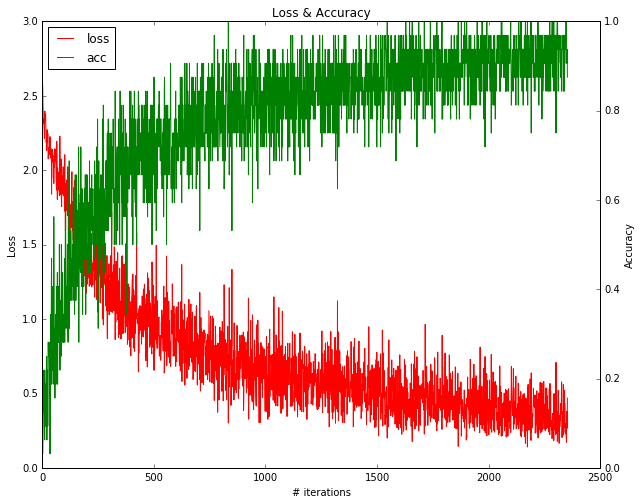

In [35]:
graph_loss_acc(train_losses, train_accs)

### HEATMAP

In [36]:
print grads.shape, X_disc_test.shape

(9441, 16) (9441, 16)


In [37]:
disc_names = list(disc_data.columns[1:-1])
print disc_names
index2disc = {i:disc for i,disc in enumerate(disc_names)}
disc_ticks = list(disc_data.columns[1:-1])
print disc_ticks

['ss', 'so', 'sx', 's-', 'os', 'oo', 'ox', 'o-', 'xs', 'xo', 'xx', 'x-', '-s', '-o', '-x', '--']
['ss', 'so', 'sx', 's-', 'os', 'oo', 'ox', 'o-', 'xs', 'xo', 'xx', 'x-', '-s', '-o', '-x', '--']


In [38]:
def heatmap_disc(idx):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(abs(grads[idx])[np.newaxis,:],cmap='hot_r',interpolation='nearest')
    ax.set_xticks(np.arange(16))
    ax.set_xticklabels(disc_ticks)
    plt.show()

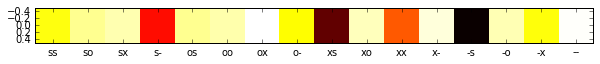

In [39]:
heatmap_disc(1)